Log read
Total training samples: 25336
Total validation samples: 4472
./data3/IMG/right_2016_12_01_13_36_07_058.jpg
Sample dimensions: (160, 320, 3)


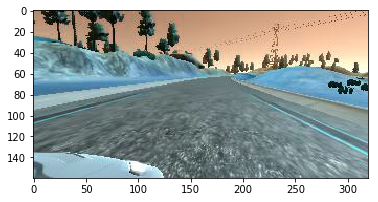

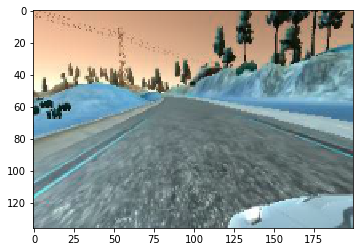

In [37]:
import cv2
import csv
import matplotlib.pyplot as plt
import numpy as np
#import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.models import Sequential
#from keras.layers import Dense, Flatten, Convolution2D, MaxPooling2D, Dropout, Activation, Cropping2D, Lambda
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, Activation, Cropping2D, Lambda


# Config: Modify when necessary
data_root = './data'
batch_size = 96
EPOCHS = 5


# read the driving log csv file
samples = []
csvfile = open(data_root+"/driving_log.csv")
reader = csv.reader(csvfile)
stear_correction = 0.2

# merge all camera data into front camera data, adjust stear angle
f = False
for line in reader:
    if not f:    # skip the first line, which does not contain any data
        f = True
        continue
    steer = float(line[3])
    samples.append([line[0], steer, False])
    samples.append([line[1], steer+stear_correction, False])
    samples.append([line[2], steer-stear_correction, False])
    if -0.0001 <= steer and steer >= 0.0001:
        samples.append([line[0], -steer, True])
        samples.append([line[1], -steer-stear_correction, True])
        samples.append([line[2], -steer+stear_correction, True])
print("Log read")
csvfile.close()
# shuffle the samples and split the training and validation sets
samples = shuffle(samples)
train_samples, validation_samples = train_test_split(samples, test_size=0.15)
print("Total training samples:", len(train_samples))
print("Total validation samples:", len(validation_samples))
ipath = data_root+'/IMG/'+train_samples[0][0].split('/')[-1]
print(ipath)
image = cv2.imread(ipath)

print("Sample dimensions:", image.shape)
timg = cv2.flip(image, flipCode=1)
timg = cv2.resize(timg, (200, 136)) 
plt.imshow(image)
plt.show()
plt.imshow(timg)
plt.show()
### plot histogram to see steer data distribution ###
#train_angles = []
#for v in train_samples:
#    train_angles.append(v[1])
#plt.hist(train_angles, 50, normed=1, facecolor='green', alpha=0.75)
#plt.xlabel('Steer Angle')
#plt.ylabel('Frequency')
#plt.show()
#############################


In [39]:

# function to generate data for the batch
def generator(samples, batch_size=64):
    pdir = data_root+'/IMG/'
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples,batch_size):
            batch_samples = samples[offset:offset+batch_size]
            images = []
            angles = []
            for batch_sample in batch_samples:
                name = pdir+batch_sample[0].split('/')[-1]
                center_image = cv2.imread(name)
                # Convert image to YUV format
                center_image = cv2.cvtColor(center_image, cv2.COLOR_BGR2YUV)
                center_image = cv2.resize(center_image, (200, 136)) 
                if batch_sample[2]:    # if True then flip the image
                    center_image = cv2.flip(center_image, flipCode=1)
                center_angle = batch_sample[1]
                images.append(center_image)
                angles.append(center_angle)
            
            X_train = np.array(images)
            y_train = np.array(angles)
            yield shuffle(X_train, y_train)

# compile and train the model using the generator function
train_generator = generator(train_samples, batch_size)
validation_generator = generator(validation_samples, batch_size)

print("Read images")

# model as per Nvidia's Model
# input of size 66x200 after cropping layer in YUV color format
model = Sequential()
# Crop the image to remove unwanted area from the image, resize to make its' height x width = 66x200
model.add(Cropping2D(cropping=((50,20), (0,0)), input_shape=(136, 200, 3)))
# Normalize the data in image
model.add(Lambda(lambda x:(x-127.5)/127.5))

model.add(Conv2D(24, (7, 7), strides=(2, 2), padding="valid"))         # input: 66x200x3, output: 30x97x24
model.add(Activation('relu'))

model.add(Conv2D(36, (5, 5), strides=(2, 2), padding="valid"))        # input: 30x97x24, output: 13x47x36
model.add(Activation('relu'))

model.add(Conv2D(48, (5, 5), strides=(2, 2), padding="valid"))        # input: 13x47x36, output: 5x22x48
model.add(Activation('relu'))

model.add(Conv2D(64, (3, 3), strides=(1, 1), padding="valid"))        # input: 5x22x48, output: 3x20x64
model.add(Activation('relu'))

model.add(Conv2D(64, (3, 3), strides=(1, 1), padding="valid"))        # input: 3x20x64, output: 1x18x64
model.add(Activation('relu'))

model.add(Flatten())            # input: 1x18x64, output: 1152
model.add(Dropout(0.3))

model.add(Dense(100))           # input: 1152, output: 100
model.add(Activation('relu'))

model.add(Dropout(0.5))

model.add(Dense(10))           # input: 100, output: 10
model.add(Activation('relu'))

model.add(Dense(1))
print("Training")

# Train the model
model.compile(loss="mse", optimizer="adam")
#model.fit_generator(train_generator, samples_per_epoch= \
#            len(train_samples), validation_data=validation_generator, \
#            nb_val_samples=len(validation_samples), nb_epoch=7, verbose=1)
model.fit_generator(train_generator, steps_per_epoch= len(train_samples)/batch_size,
            validation_data=validation_generator,
            validation_steps=len(validation_samples)/batch_size, epochs=EPOCHS, verbose=1, workers=10)
print("Trained")

# Save the model
model.save('model.h5')
print("Model saved.")

Read images
Training
Epoch 1/5
264/263 [==============================] - 43s 163ms/step - loss: 0.0213 - val_loss: 0.0180
Epoch 2/5
264/263 [==============================] - 44s 166ms/step - loss: 0.0167 - val_loss: 0.0151
Epoch 3/5
264/263 [==============================] - 41s 153ms/step - loss: 0.0150 - val_loss: 0.0138
Epoch 4/5
264/263 [==============================] - 40s 151ms/step - loss: 0.0138 - val_loss: 0.0141
Epoch 5/5
264/263 [==============================] - 42s 158ms/step - loss: 0.0129 - val_loss: 0.0126
Trained
Model saved.


In [40]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cropping2d_16 (Cropping2D)   (None, 66, 200, 3)        0         
_________________________________________________________________
lambda_19 (Lambda)           (None, 66, 200, 3)        0         
_________________________________________________________________
conv2d_76 (Conv2D)           (None, 30, 97, 24)        3552      
_________________________________________________________________
activation_108 (Activation)  (None, 30, 97, 24)        0         
_________________________________________________________________
conv2d_77 (Conv2D)           (None, 13, 47, 36)        21636     
_________________________________________________________________
activation_109 (Activation)  (None, 13, 47, 36)        0         
_________________________________________________________________
conv2d_78 (Conv2D)           (None, 5, 22, 48)         43248     
__________